# Header

진짜 그냥 낙서장.빠르게 뭐 확인할 때 쓰는 용도우

어쩌다 모든 데이터 전/후처리를 하는 게시판이 되어버린 파일...

In [1]:
import xarray as xr
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
sys.path.append('/home/hiskim1/graphcast/lib')

import his_utils, his_preprocess

# gen = xr.open_zarr("/home/hiskim1/gencast/test_output.zarr")["2m_temperature"].resample(time="1D").mean()
# gen_mean = gen.mean(dim="sample")

# gen = his_preprocess.weighted_mean(gen)
# gen_mean = his_preprocess.weighted_mean(gen_mean)
# gen -= gen_mean

# gen.isel(sample=0).plot()

In [ ]:
chunk_type={
    "time": 385704,
    "latitude": 721,
    "longitude": 1440
}

raw =xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-full_37-1h-0p25deg-chunk-1.zarr', chunks=chunk_type)
raw

In [ ]:
var_list = ['10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '2m_temperature',
 'geopotential',
 'geopotential_at_surface',
 'mean_sea_level_pressure',
 'sea_surface_temperature',
 'specific_humidity',
 'temperature',
 'u_component_of_wind',
 'v_component_of_wind',
 'vertical_velocity']

selected_raw = raw[var_list].sel(time=slice('1979-01-01T00:00:00.000000000','2022-12-31T23:00:00.000000000'))
selected_raw

In [ ]:

# =============================================================================
# 1. JAX를 이용한 분산 계산 함수 정의
# =============================================================================
@jax.jit
def jax_variance(x):
    """
    JAX를 사용해 axis=0 (여기서는 'year' 축)로 분산을 계산.
    """
    return jnp.var(x, axis=0)

# =============================================================================
# 2. DataArray에 대해 'hour_of_year'별 분산을 계산하는 함수 정의
# =============================================================================
def compute_hourly_variance(da):
    """
    입력 DataArray(예: 하나의 변수)에 대해,
      - 2월 29일(윤년)을 제거하고,
      - 각 시간에 대해 (dayofyear와 hour를 이용하여) 'hour_of_year' 좌표를 생성한 후,
      - groupby를 통해 동일한 시간 (예: 0시, 1시, …, 8759시)에 해당하는
        여러 년의 값을 모아 분산(variance)을 계산.
    
    최종적으로 시간 차원이 8760 (365×24)이 되는 DataArray를 반환합니다.
    """
    # 2월 29일(윤년) 데이터를 제거합니다.
    is_not_feb29 = ~((da.time.dt.month == 2) & (da.time.dt.day == 29))
    da = da.sel(time=is_not_feb29)

    # 'year'와 'hour_of_year' 좌표 생성 (numpy array로 변환)
    year = da.time.dt.year.values
    hour_of_year = (((da.time.dt.dayofyear - 1) * 24 + da.time.dt.hour)).values
    da = da.assign_coords(year=("time", year), hour_of_year=("time", hour_of_year))

    # 그룹별로 분산을 계산할 때, 각 그룹은 shape=(n_years, ...)
    def jax_var_wrapper(x, **kwargs):  # 추가 인자 처리
        # x는 numpy array (예: (n_years, ...)의 shape)
        x_jax = jnp.array(x)
        var_jax = jax_variance(x_jax)
        return np.array(var_jax)

    # groupby를 사용하여 hour_of_year별로 reduce(분산 계산) 수행
    da_variance = da.groupby("hour_of_year").reduce(jax_var_wrapper)

    # 결과 DataArray의 차원 이름을 'hour_of_year'에서 'time'으로 변경
    da_variance = da_variance.rename(hour_of_year="time")
    # 시간 좌표를 정렬 (0~8759)
    da_variance = da_variance.sortby("time")

    # 옵션: 결과의 time 좌표를 2000년 기준의 hourly time index로 재설정
    common_year = pd.date_range("2025-01-01", periods=8760, freq="h")
    da_variance = da_variance.assign_coords(time=common_year)
    return da_variance

# =============================================================================
# 3. 각 변수에 대해 계산 실행 및 결과 Dataset 생성
# =============================================================================

result_dataarrays = {}

for var in var_list:
    da = selected_raw[var]
    # 시간 차원이 없는 변수는 스킵 (예: geopotential_at_surface)
    if "time" in da.dims:
        print(f"Processing variable: {var}")
        result_dataarrays[var] = compute_hourly_variance(da)
    else:
        print(f"Skipping variable '{var}' as it does not have a time dimension.")

# 결과들을 하나의 Dataset으로 합칩니다.
variance_dataset = xr.Dataset(result_dataarrays)

# 결과 확인
variance_dataset.to_zarr("/geodata2/S2S/DL/GC_input/stat/era5_hourly_variance.zarr")

# WeatherBench2에서 IFS 데려오기

In [10]:
filelist = [
    "2021-01-04T12:00:00",
    "2021-01-11T12:00:00",
    "2021-01-18T12:00:00",
    "2021-01-25T12:00:00",
    "2021-02-01T12:00:00",
    "2021-02-08T12:00:00",
    "2021-02-15T12:00:00",
    "2021-02-22T12:00:00",
    "2021-03-01T12:00:00",
    "2021-03-08T12:00:00",
    "2021-03-15T12:00:00",
    "2021-03-22T12:00:00",
    "2021-03-29T12:00:00",
    "2021-04-05T12:00:00",
    "2021-04-12T12:00:00",
    "2021-04-19T12:00:00",
    "2021-04-26T12:00:00",
    "2021-05-03T12:00:00",
    "2021-05-10T12:00:00",
    "2021-05-17T12:00:00",
    "2021-05-24T12:00:00",
    "2021-05-31T12:00:00",
    "2021-06-07T12:00:00",
    "2021-06-14T12:00:00",
    "2021-06-21T12:00:00",
    "2021-06-28T12:00:00",
    "2021-07-05T12:00:00",
    "2021-07-12T12:00:00",
    "2021-07-19T12:00:00",
    "2021-07-26T12:00:00",
    "2021-08-02T12:00:00",
    "2021-08-09T12:00:00",
    "2021-08-16T12:00:00",
    "2021-08-23T12:00:00",
    "2021-08-30T12:00:00",
    "2021-09-06T12:00:00",
    "2021-09-13T12:00:00",
    "2021-09-20T12:00:00",
    "2021-09-27T12:00:00",
    "2021-10-04T12:00:00",
    "2021-10-11T12:00:00",
    "2021-10-18T12:00:00",
    "2021-10-25T12:00:00",
    "2021-11-01T12:00:00",
    "2021-11-08T12:00:00",
    "2021-11-15T12:00:00",
    "2021-11-22T12:00:00",
    "2021-11-29T12:00:00",
    "2021-12-06T12:00:00",
    "2021-12-13T12:00:00",
    "2021-12-20T12:00:00",
    "2021-12-27T12:00:00"
]


In [19]:
import xarray as xr

HRES = xr.open_zarr("gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr").sel(time=filelist)
HRES = HRES[["u_component_of_wind", "v_component_of_wind"]].sel(level=300)
HRES = HRES.squeeze().rename({"time": "initial_time"})
HRES = HRES.rename({"latitude": "lat", "longitude": "lon", "prediction_timedelta": "time"})
for init in range(52):
    part = HRES.isel(initial_time=init).squeeze()
    part.to_netcdf(f"/data/GC_output/analysis/NWP/IFS-HRES/2021/{filelist[init][:10]}.nc")

# TIGGE u, v 데이터 합치기

In [ ]:
import glob
import numpy as np

datelist = ["2021-01-04", "2021-01-11", "2021-01-18", "2021-01-25", "2021-02-01", "2021-02-08", "2021-02-15", "2021-02-22", "2021-03-01", "2021-03-08",
            "2021-03-15", "2021-03-22", "2021-03-29", "2021-04-05", "2021-04-12", "2021-04-19", "2021-04-26", "2021-05-03", "2021-05-10", "2021-05-17",
            "2021-05-24", "2021-05-31", "2021-06-07", "2021-06-14", "2021-06-21", "2021-06-28", "2021-07-05", "2021-07-12", "2021-07-19", "2021-07-26",
            "2021-08-02", "2021-08-09", "2021-08-16", "2021-08-23", "2021-08-30", "2021-09-06", "2021-09-13", "2021-09-20", "2021-09-27", "2021-10-04",
            "2021-10-11", "2021-10-18", "2021-10-25", "2021-11-01", "2021-11-08", "2021-11-15", "2021-11-22", "2021-11-29", "2021-12-06", "2021-12-13",
            "2021-12-20", "2021-12-27"]

# def preprocess (tigge:xr.Dataset):
#     tigge = tigge.expand_dims(dim={'date': [tigge.time.values[0]]})
#     tigge = tigge.rename({'time': 'ensemble', 'lev':'level'})
#     tigge = tigge.rename({'date': 'time'})
#     tigge['ensemble'] = np.arange(1, 6)
#     tigge['level'] = (tigge['level']/100).astype(int)
#     return tigge.compute()

# for date in datelist:
#     files = sorted(glob.glob(f'/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/[uv]/nc/*/[UV]_{date}.nc'))
#     files = [f for f in files if int(f.split('/')[-2]) <= 24 * 31]

#     tigge = xr.open_mfdataset(
#         files,
#         combine='by_coords',
#         preprocess=preprocess
#     )

#     for i in range (1, 6):
#         tigge.sel(ensemble=i).to_netcdf(f"/data/GC_output/analysis/NWP/S2S/2021/{date}/{i}.nc")

from dask.distributed import Client, LocalCluster

# 40개의 CPU를 사용하는 로컬 클러스터 구성
cluster = LocalCluster(n_workers=40, threads_per_worker=1)
client = Client(cluster)

# 기존 코드에 Dask 클러스터 활용 (이전 답변에서 언급한 코드 참고)
import glob
import xarray as xr
import numpy as np

def preprocess(tigge: xr.Dataset):
    tigge = tigge.expand_dims(dim={'date': [tigge.time.values[0]]})
    tigge = tigge.rename({'time': 'ensemble', 'lev': 'level'})
    tigge = tigge.rename({'date': 'time'}).isel(ensemble=slice(0, 5))
    tigge['ensemble'] = np.arange(1, 6)
    tigge['level'] = (tigge['level'] / 100).astype(int)
    return tigge

for date in datelist:
    files = sorted(glob.glob(f'/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/[uv]/nc/*/[UV]_{date}.nc'))
    files = [f for f in files if int(f.split('/')[-2]) <= 24 * 31]

    tigge = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=preprocess
    )
    
    # Dask의 분산 계산을 위해 데이터셋을 메모리에 올림
    tigge = tigge.persist()

    # 각 ensemble 별로 병렬 저장
    futures = []
    for i in range(1, 6):
        sub = tigge.sel(ensemble=i)
        future = client.submit(sub.to_netcdf, f"/data/GC_output/analysis/NWP/S2S/2021/{date}/{i}.nc")
        futures.append(future)
    
    # 모든 작업이 완료  될 때까지 대기
    client.gather(futures)


/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45219 instead
  warnings.warn(


In [45]:
xr.open_dataset("/data/GC_output/analysis/NWP/S2S/2021/2021-01-04/1.nc")

<xarray.Dataset> Size: 72MB
Dimensions:   (time: 31, level: 10, lat: 121, lon: 240)
Coordinates:
  * time      (time) datetime64[ns] 248B 2021-01-05 2021-01-06 ... 2021-02-04
  * lon       (lon) float64 2kB 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
  * lat       (lat) float64 968B 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * level     (level) int64 80B 1000 925 850 700 500 300 200 100 50 10
    ensemble  int64 8B ...
Data variables:
    u         (time, level, lat, lon) float32 36MB ...
    v         (time, level, lat, lon) float32 36MB ...
Attributes:
    CDI:          Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Jun 07 13:48:26 2024: cdo -f nc copy /home/gns404/S2S/R...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/...

# HRES specra zarr 하나로 합치기

In [23]:
import xarray as xr
import numpy as np

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]


time = xr.open_dataset("/geodata2/S2S/DL/GC_input/2021/2021-12-27.nc")["time"]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 2, 720)),
            dims=["initial_time", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "time": time,
                    "wavenumber": np.arange(0, 720)}
        )
    }

)

for date in dates:
    data = xr.open_dataset(f"/geodata2/S2S/DL/GC_input/2021/spectra_uv_{date}.nc")
    data["time"] = time
    data = data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})
    spectra = xr.concat([spectra, data], dim="initial_time")
spectra#.to_zarr("/geodata2/S2S/DL/GC_input/2021/spectra.zarr")
# spectra

<xarray.Dataset> Size: 605kB
Dimensions:       (initial_time: 52, time: 2, wavenumber: 720)
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 416B 2021-01-04 ... 2021-12-27
  * time          (time) timedelta64[ns] 16B 00:00:00 06:00:00
  * wavenumber    (wavenumber) int64 6kB 0 1 2 3 4 5 ... 714 715 716 717 718 719
Data variables:
    spectrum      (initial_time, time, wavenumber) float64 599kB 6.825e-30 .....

# S2S spectra zarr 하나로 합치기

In [33]:
xr.open_dataset("/data/GC_output/analysis/NWP/S2S/2021/2021-06-21/spectra_1.nc")

<xarray.Dataset> Size: 893kB
Dimensions:   (time: 31, level: 10, wavenumber: 360)
Dimensions without coordinates: time, level, wavenumber
Data variables:
    spectrum  (time, level, wavenumber) float64 893kB ...

In [49]:
import xarray as xr
import numpy as np

datelist = ["2021-01-04", "2021-01-11", "2021-01-18", "2021-01-25", "2021-02-01", "2021-02-08", "2021-02-15", "2021-02-22", "2021-03-01", "2021-03-08",
            "2021-03-15", "2021-03-22", "2021-03-29", "2021-04-05", "2021-04-12", "2021-04-19", "2021-04-26", "2021-05-03", "2021-05-10", "2021-05-17",
            "2021-05-24", "2021-05-31", "2021-06-07", "2021-06-14", "2021-06-21", "2021-06-28", "2021-07-05", "2021-07-12", "2021-07-19", "2021-07-26",
            "2021-08-02", "2021-08-09", "2021-08-16", "2021-08-23", "2021-08-30", "2021-09-06", "2021-09-13", "2021-09-20", "2021-09-27", "2021-10-04",
            "2021-10-11", "2021-10-18", "2021-10-25", "2021-11-01", "2021-11-08", "2021-11-15", "2021-11-22", "2021-11-29", "2021-12-06", "2021-12-13",
            "2021-12-20", "2021-12-27"]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 5, 10, 31, 360)),
            dims=["initial_time", "ensemble", "level","time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "ensemble": np.arange(1, 6),
                    "level": np.array([1000,  925,  850,  700,  500,  300,  200,  100,   50,   10]),
                    "time": np.arange(31).astype('timedelta64[ns]'),
                    "wavenumber": np.arange(0, 360)}
        )
    }
)

all_dates=[]

for date in datelist:
    dataset= []
    tmp = spectra
    for ens in range(1, 6):
        data = xr.open_dataset(f"/data/GC_output/analysis/NWP/S2S/2021/{date}/spectra_{ens}.nc")
        data = data.assign_coords(time=np.arange(31).astype('timedelta64[ns]'))
        # data = data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})
        data = data.expand_dims(dim={"ensemble": [ens]})
        # tmp = xr.concat([tmp, data], dim="ensemble")

        dataset.append(data)
    date_data = xr.concat(dataset, dim="ensemble")
    date_data = date_data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})

    all_dates.append(date_data)

spectra = xr.concat(all_dates, dim="initial_time")
spectra["level"] = np.array([1000,  925,  850,  700,  500,  300,  200,  100,   50,   10])
spectra["wavenumber"] = np.arange(0, 360)
spectra

<xarray.Dataset> Size: 232MB
Dimensions:       (initial_time: 52, ensemble: 5, time: 31, level: 10,
                   wavenumber: 360)
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 416B 2021-01-04 ... 2021-12-27
  * ensemble      (ensemble) int64 40B 1 2 3 4 5
  * time          (time) timedelta64[ns] 248B 00:00:00 ... 00:00:00.000000030
  * level         (level) int64 80B 1000 925 850 700 500 300 200 100 50 10
  * wavenumber    (wavenumber) int64 3kB 0 1 2 3 4 5 ... 354 355 356 357 358 359
Data variables:
    spectrum      (initial_time, ensemble, time, level, wavenumber) float64 232MB ...

In [52]:
spectra.to_zarr("/data/GC_output/analysis/NWP/S2S/2021/spectra.zarr")

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


# IFS-ENS zarr 하나로 합치기

In [22]:
import xarray as xr

xr.open_dataset("/geodata2/S2S/DL/GC_output/NWP/2021-02-01/5.nc").isel(time=slice(0, 61, 2))

<xarray.Dataset> Size: 258MB
Dimensions:  (time: 31, lon: 1440, lat: 721, plev: 1)
Coordinates:
  * time     (time) datetime64[ns] 248B 2021-02-01T12:00:00 ... 2021-02-16T12...
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * plev     (plev) float64 8B 3e+04
Data variables:
    u        (time, plev, lat, lon) float32 129MB ...
    v        (time, plev, lat, lon) float32 129MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu Feb 27 12:50:14 2025: cdo -f nc copy /geodata2/S2S/DL/G...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [ ]:
import xarray as xr
import numpy as np


start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
datelist = [d.strftime('%Y-%m-%d') for d in date_range]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 5, 1, 31, 720)),
            dims=["initial_time", "ensemble", "level", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "ensemble": np.arange(1, 6),
                    "level": np.array([300]),
                    "time": np.arange(31).astype('timedelta64[ns]'),
                    "wavenumber": np.arange(0, 720)}
        )
    }
)

all_dates=[]

for date in datelist:
    dataset= []
    tmp = spectra
    for ens in range(1, 6):
        data = xr.open_dataset(f"/geodata2/S2S/DL/GC_output/NWP/{date}/spectra_{ens}.nc")
        
        if data["time"].shape[0] == 61:
            # select all even time-step
            data = data.isel(time=slice(0, 61, 2))
        data = data.assign_coords(time=np.arange(31).astype('timedelta64[ns]'))
        data = data.expand_dims(dim={"ensemble": [ens]})
        dataset.append(data)

    date_data = xr.concat(dataset, dim="ensemble")
    date_data = date_data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})

    all_dates.append(date_data)

spectra = xr.concat(all_dates, dim="initial_time")
spectra["level"] = np.array([300])
spectra["wavenumber"] = np.arange(0, 720)
spectra

<xarray.Dataset> Size: 46MB
Dimensions:       (initial_time: 52, ensemble: 5, time: 31, level: 1,
                   wavenumber: 720)
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 416B 2021-01-04 ... 2021-12-27
  * ensemble      (ensemble) int64 40B 1 2 3 4 5
  * time          (time) timedelta64[ns] 248B 00:00:00 ... 00:00:00.000000030
  * level         (level) int64 8B 300
  * wavenumber    (wavenumber) int64 6kB 0 1 2 3 4 5 ... 714 715 716 717 718 719
Data variables:
    spectrum      (initial_time, ensemble, time, level, wavenumber) float64 46MB ...

In [24]:
spectra.to_zarr("/geodata2/S2S/DL/GC_output/NWP/spectra.zarr")

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


# GenCast zarr 하나로 합쳐서 `.ncl`로 던지기

In [ ]:
import xarray as xr
import pandas as pd


start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]

for day in dates:
    file = f"/geodata2/Gencast/output/2021/{day}.zarr"

data = xr.open_zarr("/geodata2/Gencast/output/2021/2021-03-15.zarr").sel(level=300).squeeze()[["u_component_of_wind", "v_component_of_wind"]]

SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (829941386.py, line 14)

# GraphCast input을 zarr 하나로 합치기

In [55]:
import xarray as xr
import pandas as pd

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]

# for day in dates:
#     xr.open_dataset(f"/geodata2/S2S/DL/GC_input/2021/{day}.nc").squeeze().sel(level=300)[["u_component_of_wind", "v_component_of_wind"]].to_netcdf(f"/geodata2/S2S/DL/GC_input/2021/uv_{day}.nc")
xr.open_dataset(f"/geodata2/S2S/DL/GC_input/2021/2021-08-09.nc").squeeze().sel(level=300)[[
    "u_component_of_wind", 
    "v_component_of_wind"]].to_netcdf(f"/geodata2/S2S/DL/GC_input/2021/uv_2021-08-09.nc")

In [57]:
import xarray as xr
import numpy as np

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]


time = xr.open_dataset("/geodata2/S2S/DL/GC_input/2021/2021-12-27.nc")["time"]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 2, 720)),
            dims=["initial_time", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "time": time,
                    "wavenumber": np.arange(0, 720)}
        )
    }
)

for date in dates:
    data = xr.open_dataset(f"/geodata2/S2S/DL/GC_input/2021/spectra_uv_{date}.nc")
    data = data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})
    spectra = xr.concat([spectra, data], dim="initial_time")
spectra.to_zarr("/geodata2/S2S/DL/GC_input/2021/spectra.zarr")
# spectra

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


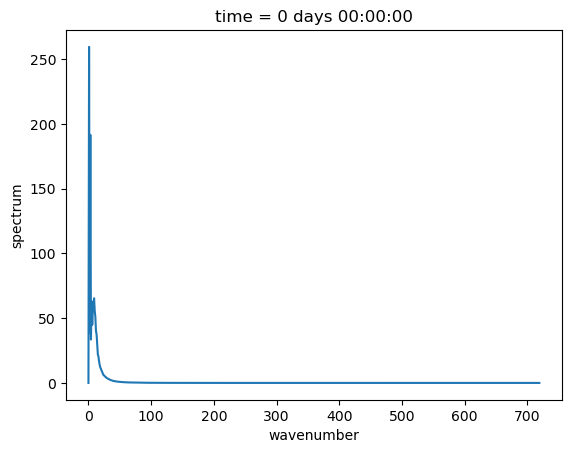

In [59]:
# for init in spectra["initial_time"]:
#     # find the index that cause inf values
#     idx = np.where(np.isinf(spectra.sel(initial_time=init)["spectrum"].values))
#     if len(idx[0]) > 0:
#         print(init, idx)

xr.open_zarr(f"/geodata2/S2S/DL/GC_input/2021/spectra.zarr")['spectrum'].mean("initial_time").isel(time=0).plot()

# GraphCast Output을 zarr 하나로 합치기

In [ ]:
import xarray as xr
import pandas as pd

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]

for day in dates:
    xr.open_dataset(f"/geodata2/S2S/DL/GC_output/2021/{day}.nc").squeeze().sel(level=300)[["u_component_of_wind",
                                                                                           "v_component_of_wind"]].rename({"u_component_of_wind":"u", 
                                                                                                                           "v_component_of_wind":"v"}).to_netcdf(f"/geodata2/S2S/DL/GC_input/2021/uv_{day}.nc")

In [52]:
import xarray as xr
import pandas as pd
import numpy as np

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]


time = xr.open_dataset("/geodata2/S2S/DL/GC_output/2021/2021-12-27.nc")["time"]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 60, 720)),
            dims=["initial_time", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "time": time,
                    "wavenumber": np.arange(0, 720)}
        )
    }

)

for date in dates:
    data = xr.open_dataset(f"/geodata2/S2S/DL/GC_output/2021/spectra_{date}.nc")
    data["time"] = time
    data = data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})
    spectra = xr.concat([spectra, data], dim="initial_time")
spectra.to_zarr("/geodata2/S2S/DL/GC_output/2021/spectra.zarr")
# spectra

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


# GenCast output을 zarr 하나로 합치기

In [53]:
import xarray as xr
import numpy as np

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]


# for day in dates:
#     data = xr.open_zarr(f"/geodata2/Gencast/output/2021/{day}.zarr").squeeze().sel(level=300)[["u_component_of_wind", "v_component_of_wind"]]
#     for ens in range(0,10):
#         data.isel(sample=ens).to_netcdf(f"/geodata2/Gencast/output/2021/{day}/{ens}.nc")
#     data.close()

day="2021-12-20"
data = xr.open_zarr(f"/geodata2/Gencast/output/2021/{day}.zarr").squeeze().sel(level=300)[["u_component_of_wind", "v_component_of_wind"]]
for ens in range(0,10):
    data.isel(sample=ens).to_netcdf(f"/geodata2/Gencast/output/2021/{day}/{ens}.nc")
data.close()

In [ ]:

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 10, 40, 360)),
            dims=["initial_time", "ensemble", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "ensemble": np.arange(0, 10),
                    "time": np.arange(40).astype('timedelta64[ns]'),
                    "wavenumber": np.arange(0, 360)}
        )
    }
)

all_dates=[]

for date in dates:
    dataset= []
    tmp = spectra
    for ens in range(0, 10):
        data = xr.open_dataset(f"/geodata2/Gencast/output/2021/{date}/spectra_{ens}.nc", engine='netcdf4')

        data = data.assign_coords(time=np.arange(40).astype('timedelta64[ns]'))
        data = data.expand_dims(dim={"ensemble": [ens]})

        dataset.append(data)
        data.close()
    date_data = xr.concat(dataset, dim="ensemble")
    date_data = date_data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})

    all_dates.append(date_data)

spectra = xr.concat(all_dates, dim="initial_time")
spectra["wavenumber"] = np.arange(0, 360)
spectra#.to_zarr("/geodata2/Gencast/output/2021/spectra.zarr")

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/zarr/api/asynchronous.py:197: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [57]:
xr.open_zarr("/geodata2/Gencast/output/2021/spectra.zarr")

<xarray.Dataset> Size: 30MB
Dimensions:       (initial_time: 52, ensemble: 10, time: 40, wavenumber: 180)
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 416B 2021-01-04 ... 2021-12-27
  * ensemble      (ensemble) int64 80B 0 1 2 3 4 5 6 7 8 9
  * time          (time) timedelta64[ns] 320B 00:00:00 ... 00:00:00.000000039
  * wavenumber    (wavenumber) int64 1kB 0 1 2 3 4 5 ... 174 175 176 177 178 179
Data variables:
    spectrum      (initial_time, ensemble, time, wavenumber) float64 30MB dask.array<chunksize=(13, 5, 20, 90), meta=np.ndarray>

# GenCast input을 zarr 하나로 합치기

In [7]:
start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]

for day in dates:
    xr.open_dataset(f"/geodata2/Gencast/input/2021-0.25/{day}.nc").squeeze().sel(level=300)[["u_component_of_wind", "v_component_of_wind"]].to_netcdf(f"/geodata2/Gencast/input/2021/uv_{day}.nc")

In [12]:
import xarray as xr
import numpy as np

start_date = '2021-01-01'
end_date = '2021-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='W-MON')
dates = [d.strftime('%Y-%m-%d') for d in date_range]


time = xr.open_dataset("/geodata2/Gencast/input/2021-0.25/2021-12-27.nc")["time"]

spectra = xr.Dataset(
    {
        "spectrum": xr.DataArray(
            data=np.zeros((0, 2, 720)),
            dims=["initial_time", "time", "wavenumber"],
            coords={"initial_time": np.array([], dtype="datetime64[ns]"),
                    "time": time,
                    "wavenumber": np.arange(0, 720)}
        )
    }

)

for date in dates:
    data = xr.open_dataset(f"/geodata2/Gencast/input/2021-0.25/spectra_uv_{date}.nc")
    data["time"] = time
    data = data.expand_dims(dim={"initial_time": [np.datetime64(date, "ns")]})
    spectra = xr.concat([spectra, data], dim="initial_time")
spectra.to_netcdf("/geodata2/Gencast/input/2021-0.25/spectra.nc")

<xarray.Dataset> Size: 605kB
Dimensions:       (initial_time: 52, time: 2, wavenumber: 720)
Coordinates:
  * initial_time  (initial_time) datetime64[ns] 416B 2021-01-04 ... 2021-12-27
  * time          (time) timedelta64[ns] 16B 00:00:00 12:00:00
  * wavenumber    (wavenumber) int64 6kB 0 1 2 3 4 5 ... 714 715 716 717 718 719
Data variables:
    spectrum      (initial_time, time, wavenumber) float64 599kB 1.77e-30 ......

# CESM PreIndustrial Control U & V를 잘 잘라서 하나로 합치기

1. ne120을 1440 * 720으로 변환 [by xESMF](https://ncar.github.io/esds/posts/2023/cam-se-analysis/#regrid-cam-se-output-using-xesmf)
2. level 복원 [by geocat](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.interpolation.interp_hybrid_to_pressure.html#geocat.comp.interpolation.interp_hybrid_to_pressure)

In [ ]:
def regrid_cam_se(dataset, weight_file):
    """
    Regrid CAM-SE output using an existing ESMF weights file.

    Parameters
    ----------
    dataset: xarray.Dataset
        Input dataset to be regridded. Must have the `ncol` dimension.
    weight_file: str or Path
        Path to existing ESMF weights file

    Returns
    -------
    regridded
        xarray.Dataset after regridding.
    """
    import numpy as np
    import xarray as xr
    import xesmf

    assert isinstance(dataset, xr.Dataset)
    weights = xr.open_dataset(weight_file)

    # input variable shape
    in_shape = weights.src_grid_dims.load().data

    # Since xESMF expects 2D vars, we'll insert a dummy dimension of size-1
    if len(in_shape) == 1:
        in_shape = [1, in_shape.item()]

    # output variable shapew
    out_shape = weights.dst_grid_dims.load().data.tolist()[::-1]

    print(f"Regridding from {in_shape} to {out_shape}")

    # Insert dummy dimension
    vars_with_ncol = [name for name in dataset.variables if "ncol" in dataset[name].dims]
    updated = dataset.copy().update(
        dataset[vars_with_ncol].transpose(..., "ncol").expand_dims("dummy", axis=-2)
    )

    # construct a regridder
    # use empty variables to tell xesmf the right shape
    # https://github.com/pangeo-data/xESMF/issues/202
    dummy_in = xr.Dataset(
        {
            "lat": ("lat", np.empty((in_shape[0],))),
            "lon": ("lon", np.empty((in_shape[1],))),
        }
    )
    dummy_out = xr.Dataset(
        {
            "lat": ("lat", weights.yc_b.data.reshape(out_shape)[:, 0]),
            "lon": ("lon", weights.xc_b.data.reshape(out_shape)[0, :]),
        }
    )

    regridder = xesmf.Regridder(
        dummy_in,
        dummy_out,
        weights=weight_file,
        method="test",
        reuse_weights=True,
        periodic=True,
    )
    display(regridder)

    # Actually regrid, after renaming
    regridded = regridder(updated.rename({"dummy": "lat", "ncol": "lon"}))

    # merge back any variables that didn't have the ncol dimension
    # And so were not regridded
    return xr.merge([dataset.drop_vars(regridded.variables), regridded])


weights = xr.open_dataset("/geodata2/Gencast/CESM2/hires/map_ne120np4_to_cmip6_720x1440_aave.20181001.nc")
u = xr.open_dataset("/geodata2/Gencast/CESM2/hires/U.nc")
ps = xr.open_dataset("/geodata2/Gencast/CESM2/hires/PS.nc")
v = xr.open_dataset("/geodata2/Gencast/CESM2/hires/V.nc")


u_regrid = regrid_cam_se(u, "/geodata2/Gencast/CESM2/hires/map_ne120np4_to_cmip6_720x1440_aave.20181001.nc")
print("U done")
v_regrid = regrid_cam_se(v, "/geodata2/Gencast/CESM2/hires/map_ne120np4_to_cmip6_720x1440_aave.20181001.nc")
print("V done")
ps_regrid = regrid_cam_se(ps, "/geodata2/Gencast/CESM2/hires/map_ne120np4_to_cmip6_720x1440_aave.20181001.nc")

In [ ]:
import xarray as xr
import geocat.comp.interpolation as gc
import numpy as np
import xesmf as xe

u = u_regrid
ps = ps_regrid
v = v_regrid

P_level_13 = np.array([
    5000., 10000., 15000., 20000., 25000., 
    30000., 40000., 50000., 60000., 70000., 
    85000., 92500., 100000.
])

u_plev = gc.interp_hybrid_to_pressure(u["U"],
                             ps=ps["PS"],
                             hyam=u["hyam"],
                             hybm=u["hybm"],
                             lev_dim="lev",
                             new_levels=P_level_13)

v_plev = gc.interp_hybrid_to_pressure(v["V"],
                             ps=ps["PS"],
                             hyam=v["hyam"],
                             hybm=v["hybm"],
                             lev_dim="lev",
                             new_levels=P_level_13)

# time_bnds = gc.interp_hybrid_to_pressure(u["time_bnds"],
#                              ps=ps["PS"],
#                              hyam=u["hyam"],
#                              hybm=u["hybm"],
#                              new_levels=P_level_13)
    
v.close()
ps.close()

data = xr.merge([u_plev, v_plev, u["time_bnds"]]).rename({"U":"u", "V":"v"})

# flatten nbnd in time_bnds
data["time_bnds"] = data["time_bnds"].isel(nbnd=0)
data = data.drop_vars("time_bnds")

<xarray.Dataset> Size: 13GB
Dimensions:    (time: 120, lat: 720, lon: 1440, plev: 13, nbnd: 2)
Coordinates:
  * time       (time) object 960B 0510-02-01 00:00:00 ... 0520-01-01 00:00:00
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * plev       (plev) float64 104B 5e+03 1e+04 1.5e+04 ... 9.25e+04 1e+05
Dimensions without coordinates: nbnd
Data variables:
    u          (time, plev, lat, lon) float32 6GB dask.array<chunksize=(120, 13, 720, 1440), meta=np.ndarray>
    v          (time, plev, lat, lon) float32 6GB dask.array<chunksize=(120, 13, 720, 1440), meta=np.ndarray>
    time_bnds  (time, nbnd) object 2kB ...

In [14]:
data.to_netcdf("/geodata2/Gencast/CESM2/hires/uv_remap.nc")

MemoryError: Unable to allocate 27.8 GiB for an array with shape (120, 30, 720, 1440) and data type int64